In [1]:
# import deeplc packages
from deeplc import DeepLC
from deeplcretrainer import deeplcretrainer

# Default
from collections import Counter
import os
import urllib.request

# specific packages
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import numpy as np

import tensorflow as tf
from tensorflow.python.eager import context

import warnings
warnings.filterwarnings('ignore')

In [5]:
df_train = pd.read_csv(r"C:\Users\wd\Desktop\DeepLC\TMT-model_remove\9-1\can1_remove.csv")
df_test = pd.read_csv(r"C:\Users\wd\Desktop\DeepLC\TMT-model_remove\9-1\can9_remove.csv")
df_train.fillna("",inplace=True)
df_test.fillna("",inplace=True)

In [6]:
df_train

,seq,modifications,tr
0,EPEVLSTMAIIVNK,0|TMT6plex|14|TMT6plex,4043.20000
1,IEGLLAAFPK,0|TMT6plex|10|TMT6plex,4040.90000
2,AALEYLEDIDLK,0|TMT6plex|12|TMT6plex,4042.10000
3,VPIWDQDIQFLPGSQK,0|TMT6plex|16|TMT6plex,4041.50000
4,DSWLDNIDWVK,0|TMT6plex|11|TMT6plex,4043.40000
...,...,...,...
7111,KKKKKKKQK,0|TMT6plex|1|TMT6plex|4|TMT6plex|9|TMT6plex,5384.73084
7112,NVTNNLK,0|TMT6plex|7|TMT6plex,1568.40000
7113,TILENSVK,0|TMT6plex|8|TMT6plex,2345.70000
7114,HFSKQMMNNMWTKTAESKIKHSLDPQFTICTYDEGDFK,13|TMT6plex|18|TMT6plex|20|TMT6plex|30|Carbami...,4625.89416


In [7]:
df_test

,seq,modifications,tr
0,MGCCGCGSCGCSGG,0|Acetyl|3|Carbamidomethyl|4|Carbamidomethyl|6...,66.636102
1,MSNGGLCGK,1|Oxidation|7|Carbamidomethyl|9|TMT6plex,87.800000
2,KSYFAK,6|TMT6plex,133.400000
3,DDGNRSRHR,,109.100000
4,AEAAAKIRK,,159.300000
...,...,...,...
64038,WCQGINNLQDVWETSEGECNVMLESR,0|TMT6plex|2|Carbamidomethyl|19|Carbamidomethyl,4043.344800
64039,QNCFDDFQCAAEYLIK,0|TMT6plex|3|Carbamidomethyl|9|Carbamidomethyl...,4044.400000
64040,GEIAQNLLSLVK,0|TMT6plex|12|TMT6plex,4042.600000
64041,WSTDDVQINDISLQDYIAVK,0|TMT6plex,4042.500000


## Calibration

In [8]:
%%capture

# The following code is not required in most cases, but here it is used to clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

# Make sure we have no NA in the dataframes
df_test['modifications'] = df_test['modifications'].fillna("")
df_train['modifications'] = df_train['modifications'].fillna("")

# Call DeepLC with the downloaded models, say that we use GAM calibration
dlc = DeepLC(
        path_model=[r"C:\Users\wd\Desktop\DeepLC\TMT_model\full_hc_tmt_data_consensus_ticnum_filtered_5ee8aaa41d387bfffb8cda966348937c.hdf5",r"C:\Users\wd\Desktop\DeepLC\TMT_model\full_hc_tmt_data_consensus_ticnum_filtered_8c488fed5e0d0b07cf217fe3c30e55c6.hdf5"],
        batch_num=1024000,
        pygam_calibration=True
)

# Perform calibration, make predictions and calculate metrics
dlc.calibrate_preds(seq_df=df_train)
preds_calib = dlc.make_preds(seq_df=df_test)

mae_calib = sum(abs(df_test["tr"]-preds_calib))/len(df_test["tr"].index)
perc95_calib = np.percentile(abs(df_test["tr"]-preds_calib),95)*2
cor_calib = pearsonr(df_test["tr"],preds_calib)[0]

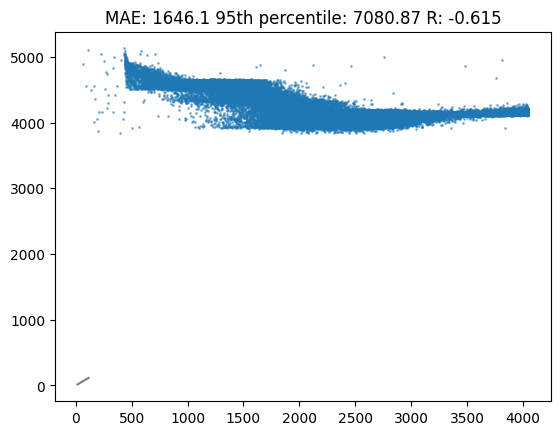

In [9]:
%matplotlib inline

plt.title(f"MAE: {round(mae_calib,2)} 95th percentile: {round(perc95_calib,2)} R: {round(cor_calib,3)}")
plt.scatter(df_test["tr"],preds_calib,s=1,alpha=0.5)
plt.plot([15,115],[15,115],c="grey")
plt.show()

## New train

In [10]:
%%capture

# The following code is not required in most cases, but here it is used to clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

# For training new models we need to use a file, so write the train df to a file
df_train.to_csv("train.csv",index=False)
df_train_file = "train.csv"

# Here we will train a new model so we keep the 'mods_transfer_learning' empty
models_subtr = deeplcretrainer.retrain(
    [df_train_file],
    mods_transfer_learning=[],
    freeze_layers=False,
    n_epochs=100
)

# The following code is not required in most cases, but here it is used to clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

# Make a DeepLC object with the models trained previously
dlc = DeepLC(
        path_model=models_subtr,
        batch_num=1024000,
        pygam_calibration=False
)

# Perform calibration, make predictions and calculate metrics
dlc.calibrate_preds(seq_df=df_train)
preds_newtrain = dlc.make_preds(seq_df=df_test)

mae_newtrain = sum(abs(df_test["tr"]-preds_newtrain))/len(df_test["tr"].index)
perc95_newtrain = np.percentile(abs(df_test["tr"]-preds_newtrain),95)*2
cor_newtrain = pearsonr(df_test["tr"],preds_newtrain)[0]

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


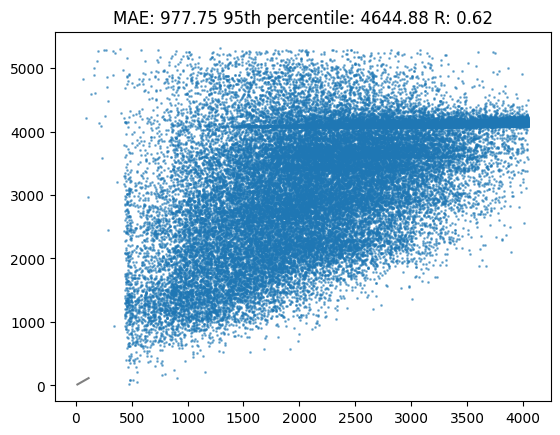

In [11]:
%matplotlib inline

plt.title(f"MAE: {round(mae_newtrain,2)} 95th percentile: {round(perc95_newtrain,2)} R: {round(cor_newtrain,3)}")
plt.scatter(df_test["tr"],preds_newtrain,s=1,alpha=0.5)
plt.plot([15,115],[15,115],c="grey")
plt.show()

## Transfer learning

In [12]:
%%capture

# The following code is not required in most cases, but here it is used to clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

# For training new models we need to use a file, so write the train df to a file
df_train.to_csv("train.csv",index=False)
df_train_file = "train.csv"

# Here we will apply transfer learning we specify previously trained models in the 'mods_transfer_learning'
models = deeplcretrainer.retrain(
    [df_train_file],
    mods_transfer_learning=[r"C:\Users\wd\Desktop\DeepLC\TMT_model\full_hc_tmt_data_consensus_ticnum_filtered_5ee8aaa41d387bfffb8cda966348937c.hdf5",r"C:\Users\wd\Desktop\DeepLC\TMT_model\full_hc_tmt_data_consensus_ticnum_filtered_8c488fed5e0d0b07cf217fe3c30e55c6.hdf5"],
    freeze_layers=True,
    n_epochs=10,
    freeze_after_concat=1
);

# The following code is not required in most cases, but here it is used to clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

# Make a DeepLC object with the models trained previously
dlc = DeepLC(
        path_model=models,
        batch_num=1024000,
        pygam_calibration=False
)

# Perform calibration, make predictions and calculate metrics
dlc.calibrate_preds(seq_df=df_train)
preds_transflearn = dlc.make_preds(seq_df=df_test)

mae_transflearn = sum(abs(df_test["tr"]-preds_transflearn))/len(df_test["tr"].index)
perc95_transflearn = np.percentile(abs(df_test["tr"]-preds_transflearn),95)*2
cor_transflearn = pearsonr(df_test["tr"],preds_transflearn)[0]

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


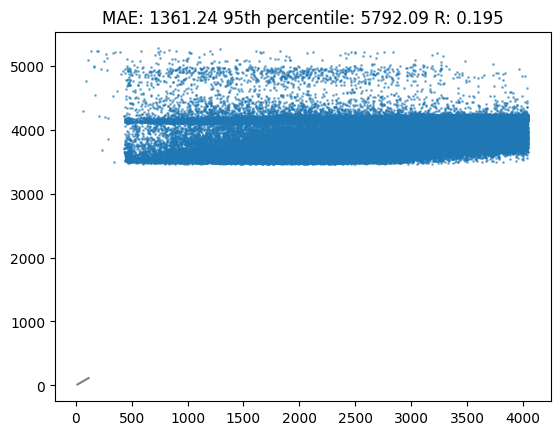

In [13]:
%matplotlib inline

plt.title(f"MAE: {round(mae_transflearn,2)} 95th percentile: {round(perc95_transflearn,2)} R: {round(cor_transflearn,3)}")
plt.scatter(df_test["tr"],preds_transflearn,s=1,alpha=0.5)
plt.plot([15,115],[15,115],c="grey")
plt.show()